In [97]:
import pandas as pd
import numpy as np

# import matplotlib as plt
import matplotlib.pyplot as plt
import scipy
from skspatial.objects import LineSegment, Line
from enum import Enum

In [98]:
VIA_DIAM = 0.8
VIA_DRILL = 0.4
STATOR_HOLE_RADIUS = 5
TRACK_WIDTH = 0.2
TRACK_SPACING = 0.2
TURNS = 8
STATOR_RADIUS = 18
COIL_CENTER_RADIUS = 11
USE_SPIRAL = False
Layer = Enum("Layer", "FRONT BACK")

# Arbitrary Coil Generation

In [99]:
template = [(-1.5, -0.1), (1.5, -2), (2.0, -1), (2.0, 1), (1.5, 2), (-1.5, 0.1)]

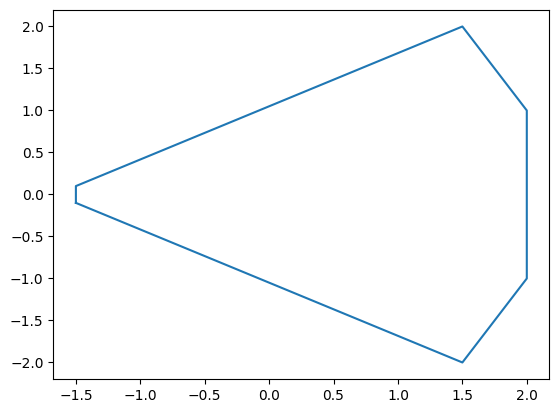

In [100]:
# plot the template shape wrapping around to the first point
plt.plot(
    [x for x, y in template] + [template[0][0]],
    [y for x, y in template] + [template[0][1]],
)

In [101]:
# this speeds things up dramatically as we only have to compute the line intersections once
# there are probably much faster ways of doing this - we're just doing a brute force search
# for the intersections - consult algorithms from games for inspiration...
def get_template_point_cache(template):
    # sweep a line from the origin through 360 degress times the number of turns in 1 degree increments
    # and find the intersection points with the template shape
    cache = {}
    for angle in np.arange(0, 360 + 1, 1):
        line = LineSegment(
            np.array([0, 0]),
            np.array(
                [1000 * np.cos(np.deg2rad(angle)), 1000 * np.sin(np.deg2rad(angle))]
            ),
        )
        for i in range(len(template)):
            segment = LineSegment(
                np.array(template[i]), np.array(template[(i + 1) % len(template)])
            )
            try:
                intersection = line.intersect_line_segment(segment)
                if intersection is not None:
                    cache[angle] = (intersection, segment)
            except ValueError:
                try:
                    # nudge the angle slightly
                    new_angle = angle + 0.1
                    line = LineSegment(
                        np.array([0, 0]),
                        np.array(
                            [
                                1000 * np.cos(np.deg2rad(new_angle)),
                                1000 * np.sin(np.deg2rad(new_angle)),
                            ]
                        ),
                    )
                    intersection = line.intersect_line_segment(segment)
                    if intersection is not None:
                        cache[angle] = (intersection, segment)
                except ValueError:
                    pass
    return cache


def get_point(angle, template, layer, spacing, cache):
    if layer == Layer.BACK:
        angle = angle + 180
    intersection, segment = cache[angle % 360]
    return intersection, segment


# get the points in a coil shape
# Use reverse for bottom layer (basically flips the y coordinate so that the coil goes in the opposite direction)
# Also rotates the endpoints by 90 degress so that the exit point on the bottom layer is to the left hand side
def get_points(template, turns, spacing, layer=Layer.FRONT, cache=None):
    if cache is None:
        cache = get_template_point_cache(template)
    coil_points = []
    last_segment = None
    for angle in np.arange(0, 360 * turns + 1, 1):
        offset = spacing * angle / 360
        intersection, segment = get_point(angle, template, layer, spacing, cache)
        vector = np.array(segment.point_a) - np.array(segment.point_b)
        normal = vector / np.linalg.norm(vector)
        # rotate the vector 90 degrees
        normal = np.array([-normal[1], normal[0]])
        # move the intersection point along the normal vector by the spacing
        coil_point = intersection + normal * offset
        if layer == Layer.BACK:
            coil_points.append((coil_point[0], -coil_point[1], segment))
        else:
            coil_points.append((coil_point[0], coil_point[1], segment))
    # run through the generated coil points and where the line segments change add a point that is the intersection of the previous and next lines
    # this prevents any corner cutting
    points = []
    last_segment = coil_points[0][2]
    for i in range(len(coil_points)):
        x, y, segment = coil_points[i]
        same_segment = (
            (last_segment.point_a == segment.point_a).all()
            and (last_segment.point_b == segment.point_b).all()
        ).all()
        if (not same_segment) and i > 2 and i < len(coil_points) - 2:
            # create a line from the previous two points
            line = Line(
                np.array(coil_points[i - 2][0:2]),
                np.array(coil_points[i - 2][0:2]) - np.array(coil_points[i - 1][0:2]),
            )
            # create a line from the next two points
            line2 = Line(
                np.array(coil_points[i][0:2]),
                np.array(coil_points[i][0:2]) - np.array(coil_points[i + 1][0:2]),
            )
            # find the intersection of the two lines
            intersection = line.intersect_line(line2)
            # add the intersection point to the list of points
            points.append(intersection)
        last_segment = segment
        points.append((x, y))
    return points


def optimize_points(points):
    # follow the line and remove points that are in the same direction as the previous poin
    # keep doing this until the direction changes significantly
    # this is a very simple optimization that removes a lot of points
    # it's not perfect but it's a good start
    optimized_points = []
    for i in range(len(points)):
        if i == 0:
            optimized_points.append(points[i])
        else:
            vector1 = np.array(points[i]) - np.array(points[i - 1])
            vector2 = np.array(points[(i + 1) % len(points)]) - np.array(points[i])
            length1 = np.linalg.norm(vector1)
            length2 = np.linalg.norm(vector2)
            if length1 > 0 and length2 > 0:
                dot = np.dot(vector1, vector2) / (length1 * length2)
                # clamp dot between -1 and 1
                dot = max(-1, min(1, dot))
                angle = np.arccos(dot)
                if angle > np.deg2rad(5):
                    optimized_points.append(points[i])
    print("Optimised from {} to {} points".format(len(points), len(optimized_points)))
    return optimized_points


def chaikin(points, iterations):
    if iterations == 0:
        return points
    l = len(points)
    smoothed = []
    for i in range(l - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        smoothed.append([0.9 * x1 + 0.1 * x2, 0.9 * y1 + 0.1 * y2])
        smoothed.append([0.1 * x1 + 0.9 * x2, 0.1 * y1 + 0.9 * y2])
    smoothed.append(points[l - 1])
    return chaikin(smoothed, iterations - 1)

In [102]:
cache = get_template_point_cache(template)

In [103]:
if not USE_SPIRAL:
    points_f = get_points(
        template, TURNS, TRACK_SPACING + TRACK_WIDTH, Layer.FRONT, cache
    )
    points_b = get_points(
        template, TURNS, TRACK_SPACING + TRACK_WIDTH, Layer.BACK, cache
    )

    points_f = [(0, 0)] + chaikin(optimize_points(points_f), 3)
    points_b = [(0, 0)] + chaikin(optimize_points(points_b), 3)
    print("Track points", len(points_f), len(points_b))
else:
    print("Using spiral")

Optimised from 2929 to 50 points
Optimised from 2929 to 50 points
Track points 394 394


# Basic Spiral Coil Generation

In [104]:
def get_spiral(turns, start_radius, thickness, layer=Layer.FRONT):
    points = []
    # create a starting point in the center
    for angle in np.arange(0, turns * 360, 1):
        radius = start_radius + thickness * angle / 360
        if layer == Layer.BACK:
            x = radius * np.cos(np.deg2rad(angle + 180))
            y = radius * np.sin(np.deg2rad(angle + 180))
            points.append((x, -y))
        else:
            x = radius * np.cos(np.deg2rad(angle))
            y = radius * np.sin(np.deg2rad(angle))
            points.append((x, y))
    return points

In [105]:
if USE_SPIRAL:
    points_f = get_spiral(
        TURNS, VIA_DIAM + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.FRONT
    )
    points_b = get_spiral(
        TURNS, VIA_DIAM + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.BACK
    )

    points_f = [(0, 0)] + points_f
    points_b = [(0, 0)] + points_b
    print("Track points", len(points_f), len(points_b))
else:
    print("Using template")

Using template


# Generate PCB Layout

In [106]:
# calculat the total length of the track to compute the resistance
total_length_front = 0
for i in range(len(points_f) - 1):
    total_length_front += np.linalg.norm(
        np.array(points_f[i + 1]) - np.array(points_f[i])
    )
print("Total length front", total_length_front)

total_length_back = 0
for i in range(len(points_b) - 1):
    total_length_back += np.linalg.norm(
        np.array(points_b[i + 1]) - np.array(points_b[i])
    )
print("Total length back", total_length_back)

Total length front 183.9872139925838
Total length back 183.77066506609512


In [107]:
vias = []

angle_A = 0
angle_B = 120
angle_C = 240

# get the point on an arc at the given angle
def get_arc_point(angle, radius):
    return (
        radius * np.cos(np.deg2rad(angle)),
        radius * np.sin(np.deg2rad(angle)),
    )


# draw an arc
def draw_arc(start_angle, end_angle, radius, step=10):
    points = []
    for angle in np.arange(start_angle, end_angle + step, step):
        x = radius * np.cos(np.deg2rad(angle))
        y = radius * np.sin(np.deg2rad(angle))
        points.append((x, y))
    return points


# roate the points by the required angle
def rotate(points, angle):
    return [
        [
            x * np.cos(np.deg2rad(angle)) - y * np.sin(np.deg2rad(angle)),
            x * np.sin(np.deg2rad(angle)) + y * np.cos(np.deg2rad(angle)),
        ]
        for x, y in points
    ]


# move the points out to the distance at the requited angle
def translate(points, distance, angle):
    return [
        [
            x + distance * np.cos(np.deg2rad(angle)),
            y + distance * np.sin(np.deg2rad(angle)),
        ]
        for x, y in points
    ]


def create_via(point):
    return {"x": point[0], "y": point[1]}


# flip the y coordinate
def flip(points):
    return [[x, -y] for x, y in points]


# the main coils
coil_A_f = translate(rotate(points_f, angle_A), COIL_CENTER_RADIUS, angle_A)
coil_A_b = translate(rotate(points_b, angle_A), COIL_CENTER_RADIUS, angle_A)

coil_B_f = translate(rotate(points_f, angle_B), COIL_CENTER_RADIUS, angle_B)
coil_B_b = translate(rotate(points_b, angle_B), COIL_CENTER_RADIUS, angle_B)

coil_C_f = translate(rotate(points_f, angle_C), COIL_CENTER_RADIUS, angle_C)
coil_C_b = translate(rotate(points_b, angle_C), COIL_CENTER_RADIUS, angle_C)

# the opposite coils - for more power!
angle_A_opp = angle_A + 180
angle_B_opp = angle_B + 180
angle_C_opp = angle_C + 180

coil_A_opp_f = translate(
    rotate(flip(points_f), angle_A_opp), COIL_CENTER_RADIUS, angle_A_opp
)
coil_A_opp_b = translate(
    rotate(flip(points_b), angle_A_opp), COIL_CENTER_RADIUS, angle_A_opp
)

coil_B_opp_f = translate(
    rotate(flip(points_f), angle_B_opp), COIL_CENTER_RADIUS, angle_B_opp
)
coil_B_opp_b = translate(
    rotate(flip(points_b), angle_B_opp), COIL_CENTER_RADIUS, angle_B_opp
)

coil_C_opp_f = translate(
    rotate(flip(points_f), angle_C_opp), COIL_CENTER_RADIUS, angle_C_opp
)
coil_C_opp_b = translate(
    rotate(flip(points_b), angle_C_opp), COIL_CENTER_RADIUS, angle_C_opp
)

# connect the front and back coils together
vias.append(create_via(get_arc_point(angle_A, COIL_CENTER_RADIUS)))
vias.append(create_via(get_arc_point(angle_B, COIL_CENTER_RADIUS)))
vias.append(create_via(get_arc_point(angle_C, COIL_CENTER_RADIUS)))
vias.append(create_via(get_arc_point(angle_A_opp, COIL_CENTER_RADIUS)))
vias.append(create_via(get_arc_point(angle_B_opp, COIL_CENTER_RADIUS)))
vias.append(create_via(get_arc_point(angle_C_opp, COIL_CENTER_RADIUS)))

# connect the front copper opposite coils together
common_connection_radius = STATOR_RADIUS - (TRACK_WIDTH + TRACK_SPACING)
common_coil_connections_b = draw_arc(angle_A_opp, angle_C_opp, common_connection_radius)
coil_A_opp_f.append(get_arc_point(angle_A_opp, common_connection_radius))
coil_B_opp_f.append(get_arc_point(angle_B_opp, common_connection_radius))
coil_C_opp_f.append(get_arc_point(angle_C_opp, common_connection_radius))

vias.append(create_via(get_arc_point(angle_A_opp, common_connection_radius)))
vias.append(create_via(get_arc_point(angle_B_opp, common_connection_radius)))
vias.append(create_via(get_arc_point(angle_C_opp, common_connection_radius)))

# route coil A and coil C round to coil B so we have a good place to connect to them
coil_input_radius = STATOR_RADIUS - (TRACK_WIDTH + TRACK_SPACING * 2 + VIA_DIAM / 2)
coil_A_input_connection_b = draw_arc(angle_A, 80, coil_input_radius)
coil_B_input_connection_f = draw_arc(90, angle_B, coil_input_radius)
coil_C_input_connection_b = draw_arc(100, angle_C, coil_input_radius)

coil_A_f.append(coil_A_input_connection_b[0])
coil_B_f.append(get_arc_point(angle_B, coil_input_radius))
coil_C_f.append(coil_C_input_connection_b[-1])

vias.append(create_via(coil_A_input_connection_b[0]))
vias.append(create_via(coil_C_input_connection_b[-1]))


# wires for connecting to opposite coils
connection_radius1 = STATOR_HOLE_RADIUS + (TRACK_SPACING)
connection_radius2 = connection_radius1 + (TRACK_SPACING + VIA_DIAM / 2)

# draw a 45 degree line from each coil at connection radius 1
# then connect up to connection radius 2
# draw a 45 degree line to the opposite coil

# coil A
coil_A_b.append(get_arc_point(angle_A, connection_radius1))
coil_A_opp_b.append(get_arc_point(angle_A_opp, connection_radius2))
a_connection_b = draw_arc(angle_A, angle_A + 90, connection_radius1)
a_connection_f = draw_arc(angle_A + 90, angle_A + 180, connection_radius2)
a_connection_b.append(a_connection_f[0])

# coil B
coil_B_b.append(get_arc_point(angle_B, connection_radius1))
coil_B_opp_b.append(get_arc_point(angle_B_opp, connection_radius2))
b_connection_b = draw_arc(angle_B, angle_B + 90, connection_radius1)
b_connection_f = draw_arc(angle_B + 90, angle_B + 180, connection_radius2)
b_connection_b.append(b_connection_f[0])

# coil C
coil_C_b.append(get_arc_point(angle_C, connection_radius1))
coil_C_opp_b.append(get_arc_point(angle_C_opp, connection_radius2))
c_connection_b = draw_arc(angle_C, angle_C + 90, connection_radius1)
c_connection_f = draw_arc(angle_C + 90, angle_C + 180, connection_radius2)
c_connection_b.append(c_connection_f[0])

vias.append(create_via(a_connection_f[0]))
vias.append(create_via(b_connection_f[0]))
vias.append(create_via(c_connection_f[0]))

vias.append(create_via(a_connection_f[-1]))
vias.append(create_via(b_connection_f[-1]))
vias.append(create_via(c_connection_f[-1]))

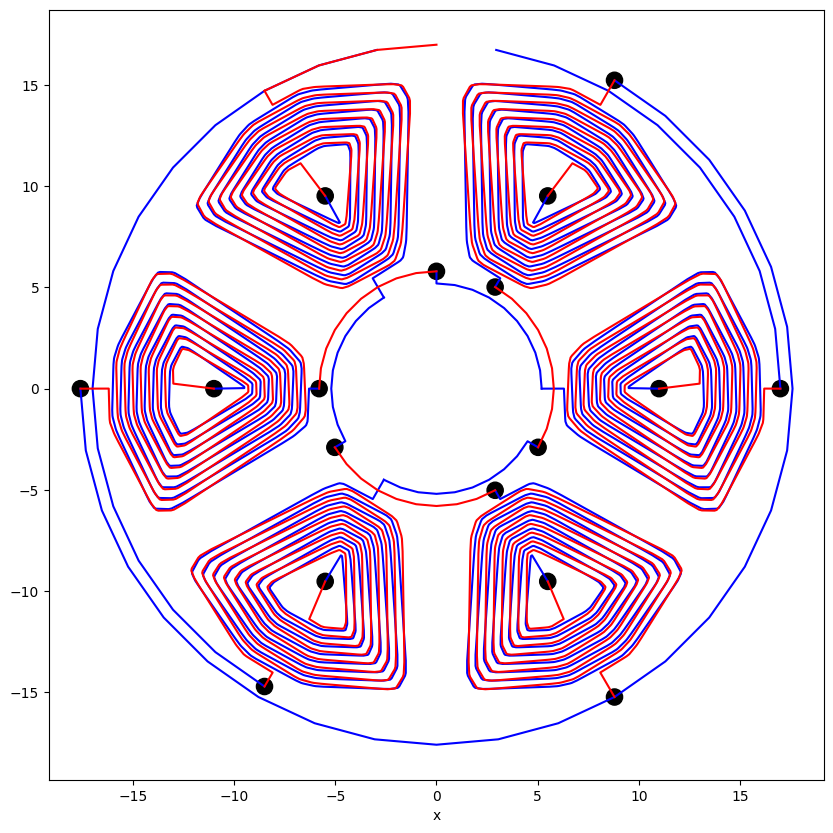

In [108]:
def create_track(points):
    return [{"x": x, "y": y} for x, y in points]


# dump out the results to json
json_result = {
    "parameters": {
        "trackWidth": TRACK_WIDTH,
        "statorHoleRadius": STATOR_HOLE_RADIUS,
        "statorRadius": STATOR_RADIUS,
        "viaDiameter": VIA_DIAM,
        "viaDrillDiameter": VIA_DRILL,
    },
    "vias": vias,
    "silk": [
        {
            "x": COIL_CENTER_RADIUS * np.cos(np.deg2rad(angle_A)),
            "y": COIL_CENTER_RADIUS * np.sin(np.deg2rad(angle_A)),
            "text": "A",
        },
        {
            "x": COIL_CENTER_RADIUS * np.cos(np.deg2rad(angle_B)),
            "y": COIL_CENTER_RADIUS * np.sin(np.deg2rad(angle_B)),
            "text": "B",
        },
        {
            "x": COIL_CENTER_RADIUS * np.cos(np.deg2rad(angle_C)),
            "y": COIL_CENTER_RADIUS * np.sin(np.deg2rad(angle_C)),
            "text": "C",
        },
    ],
    "tracks": {
        "f": [
            create_track(points)
            for points in [
                coil_A_f,
                coil_A_opp_f,
                coil_B_f,
                coil_B_opp_f,
                coil_C_f,
                coil_C_opp_f,
                a_connection_f,
                b_connection_f,
                c_connection_f,
                coil_B_input_connection_f,
            ]
        ],
        "b": [
            create_track(points)
            for points in [
                coil_A_b,
                coil_A_opp_b,
                coil_B_b,
                coil_B_opp_b,
                coil_C_b,
                coil_C_opp_b,
                common_coil_connections_b,
                a_connection_b,
                b_connection_b,
                c_connection_b,
                coil_A_input_connection_b,
                coil_C_input_connection_b,
            ]
        ],
    },
}

import json

json.dump(json_result, open("coil.json", "w"))


# df = pd.DataFrame(coil_A_f, columns=["x", "y"])
# ax = df.plot.line(x="x", y="y", label="Coil A", color="blue")
# ax.axis("equal")
# df = pd.DataFrame(coil_A_b, columns=["x", "y"])
# ax = df.plot.line(x="x", y="y", label="Coil B", color="green")
# ax.axis("equal")


# plot the back tracks
ax = None
for track in json_result["tracks"]["b"]:
    df = pd.DataFrame(track, columns=["x", "y"])
    ax = df.plot.line(x="x", y="y", color="blue", ax=ax)
    ax.axis("equal")

# plot the front tracks
for track in json_result["tracks"]["f"]:
    df = pd.DataFrame(track, columns=["x", "y"])
    ax = df.plot.line(x="x", y="y", color="red", ax=ax)
    ax.axis("equal")

# hide the legend
ax.legend().set_visible(False)
# make the plot bigger
ax.figure.set_size_inches(10, 10)

# plot the vias
for via in json_result["vias"]:
    ax.add_patch(
        plt.Circle(
            (via["x"], via["y"]),
            radius=VIA_DIAM / 2,
            fill=True,
            color="black",
        )
    )